In [2]:
import h5py
import nibabel as nib
import numpy as np
import os
import math
import PIL
from PIL import Image
import sys
from skimage import measure
import matplotlib.pyplot as plt

In [ ]:
volumeDirs = ["Dataset/TrainVolumes/", "Dataset/ValidationVolumes/", "Dataset/TestVolumes/"]
segmentationDirs = ["Dataset/TrainSegmentations/", "Dataset/ValidationSegmentations/", "Dataset/TestSegmentations/"]

fileNames = ["TrainDataset.hdf5", "ValidationDataset.hdf5", "TestDataset.hdf5"]

numFiles = []

for fileName in volumeDirs:
    numFiles.append(len([name for name in os.listdir(fileName) if os.path.isfile(os.path.join(fileName, name))]))

#Percent of slices to keep from each scan, starts from middle of array
keepRate = 0.3

#Resize all slices/segmentations to imageDim x imageDim
imageDim = 256

In [ ]:
def window_level(vol, window_center, window_width): 
    img_min = window_center - window_width // 2 
    img_max = window_center + window_width // 2 
    window_image = vol.copy() 
    window_image[window_image < img_min] = img_min 
    window_image[window_image > img_max] = img_max 

    return window_image 

In [ ]:
livers = []
total = []

minVal = float('inf')
maxVal = float('-inf')

for volumeDir in volumeDirs:
    for i, name in enumerate(os.listdir(volumeDir)):
        #Disregards hidden files
        if name[0] == '.':
            continue

        ctScan = nib.load(volumeDir + name)
        volumeData = ctScan.get_fdata()

        minVal = min(np.amin(volumeData), minVal)
        maxVal = max(np.amax(volumeData), maxVal)

for i in range(len(volumeDirs)):
    volumeDir = volumeDirs[i]
    segmentationDir = segmentationDirs[i]

    numLivers = 0
    totalSlices = 0

    file = h5py.File(fileNames[i], "w")

    sliceNum = 0

    for i, name in enumerate(os.listdir(volumeDir)):
        #Disregards hidden files
        if name[0] == '.':
            continue

        #Loads segmentation and volume data from .nii file
        ctScan = nib.load(volumeDir + name)
        volumeData = ctScan.get_fdata()

        volumeData = window_level(volumeData, 40, 400)

        segmentation = nib.load(segmentationDir + os.listdir(segmentationDir)[i])
        segmentData = segmentation.get_fdata()

        #Loops through all usable slices and adds data to h5 file
        #Finds middle index, subtracts half * keepRate from it, goes to middle index + half * keepRate
        for plane in range(math.ceil(((volumeData.shape[2] - 1) / 2) - (((volumeData.shape[2] - 1) / 2) * keepRate)), 
        math.floor(((volumeData.shape[2] - 1) / 2) + (((volumeData.shape[2] - 1) / 2) * keepRate))):

            volumeSlice = np.array(Image.fromarray(volumeData[:,:,plane].astype(np.int16)).resize((imageDim, imageDim), Image.BILINEAR))
            segmentSlice = segmentData[:,:,plane].astype(np.int16)

            volumeSlice = volumeSlice.astype(np.float16)

            volumeSlice -= minVal
            volumeSlice /= maxVal - minVal

            #Gets max value of current segmenation, limits it to 1 (1 if contains liver, 0 if not)
            label = min(np.amax(segmentSlice), 1)
            segmentSlice = np.array(Image.fromarray(segmentSlice).resize((imageDim, imageDim), Image.NEAREST))

            numLivers += label
            totalSlices += 1

            #Creates subgroup for current slice in current scan, adds slice/segmentation/label data
            currSlice = file.create_group("Slice" + str(sliceNum))
            currSlice.create_dataset("Slice", data=volumeSlice)
            currSlice.create_dataset("Segmentation", data=segmentSlice)
            currSlice.attrs.create("ImageLabel", label, (1,), "int")

            sliceNum += 1

    livers.append(numLivers)
    total.append(totalSlices)

print(f"Liver Present: {livers} Total: {total}")

file.close()

In [ ]:
for fileName in fileNames:
    dataFile = h5py.File(fileName, 'r')
    print(list(dataFile.keys()))
        
    for slice in dataFile:
        print(dataFile[slice]["Slice"])
        print(dataFile[slice]["Segmentation"])
        print(dataFile[slice].attrs.get("ImageLabel"))

dataFile.close()

36


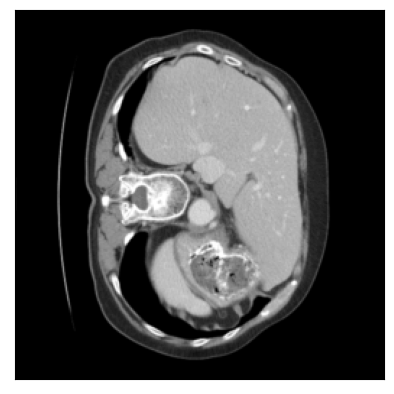

In [3]:
def clamp(iter, min, max):
    for i in range(len(iter)):
        for j in range(len(iter[i])):
            if iter[i][j] > max:
                iter[i][j] = max
            elif iter[i][j] < min:
                iter[i][j] = min

    return iter

sliceNum = 21
groundTruthFile = h5py.File("Datasets/Scan1Dataset.hdf5", 'r')
print(len(groundTruthFile.keys()))
clamped = clamp(list(groundTruthFile["Slice" + str(sliceNum)]["Segmentation"]), 0, 1)
groundTruthContours = measure.find_contours(clamped, 0.9)
fig, ax = plt.subplots()
ax.imshow(list(groundTruthFile["Slice" + str(sliceNum)]["Slice"]), cmap=plt.cm.gray)

#contour = groundTruthContours[0]
#ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

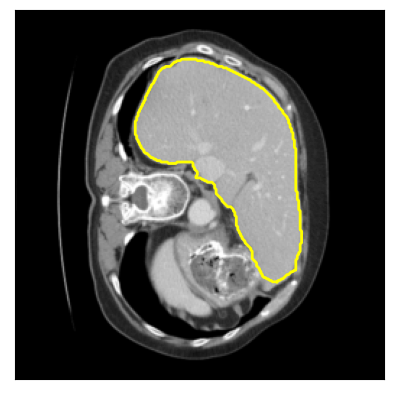

In [40]:
#predictFile = h5py.File("BaselineMasksScan1")
#predictFile = h5py.File("JointMasksScan1")
predictFile = h5py.File("PretrainMasksScan1")
contours = measure.find_contours(list(predictFile["Slice" + str(sliceNum)]), 0.9)

fig, ax = plt.subplots()
ax.imshow(list(groundTruthFile["Slice" + str(sliceNum)]["Slice"]), cmap=plt.cm.gray)

contour = contours[0]
ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='yellow')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()